# Chapter 2: Data preparation

## Import


In [3]:
import os
import json
import csv
import pandas as pd
import seaborn as sns

## turn json to csv file


In [68]:
labels = ["CE", "ENV", "BME", "PE", "METAL", "ME", "EE", "CPE", "OPTIC",
          "NANO", "CHE", "MATENG", "AGRI", "EDU", "IE", "SAFETY", "MATH", "MATSCI"]


def train_to_csv(r, w):
    with open(r, "r") as f:
        data = json.load(f)

    with open(w, "w", newline='', encoding='utf-8') as csv_file:
        fieldnames = ["id", "text"] + labels
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for key, value in data.items():
            row = {"id": key, "text": value['Title'] + ' ' + value["Abstract"]}
            for field in fieldnames[2:]:
                row[field] = 1 if field in value["Classes"] else 0
            writer.writerow(row)


def test_to_csv(r, w):
    with open(r, "r") as f:
        data = json.load(f)
    with open(w, "w", newline='', encoding='utf-8') as csv_file:
        fieldnames = ['id', 'text']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for key, value in data.items():
            row = {"id": key,
                   "text": value["Title"] + " " + value["Abstract"]}
            writer.writerow(row)

In [ ]:
os.chdir('..')
train_to_csv("data/student_json/train_for_student.json",
             "data/student_csv/train_for_student.csv")

test_to_csv("data/student_json/test_for_student.json",
            "data/student_csv/test_for_student.csv")

## Load Data


In [4]:
train_data = pd.read_csv('data/student_csv/train_for_student.csv')
test_data = pd.read_csv('data/student_csv/test_for_student.csv')

## Count the number of words in each article.

In [17]:
train_data['count_word'] = train_data['text'].apply(lambda x: len(x.split()))
test_data['count_word'] = train_data['text'].apply(lambda x: len(x.split()))

In [10]:
train_data['count_word'].describe()

count    454.000000
mean     192.096916
std       58.923375
min       63.000000
25%      149.250000
50%      189.000000
75%      224.750000
max      464.000000
Name: count_word, dtype: float64

In [11]:
test_data['count_word'].describe()

count    151.000000
mean     194.768212
std       60.669866
min       84.000000
25%      146.500000
50%      192.000000
75%      232.000000
max      399.000000
Name: count_word, dtype: float64

## Plot histogram of word counts

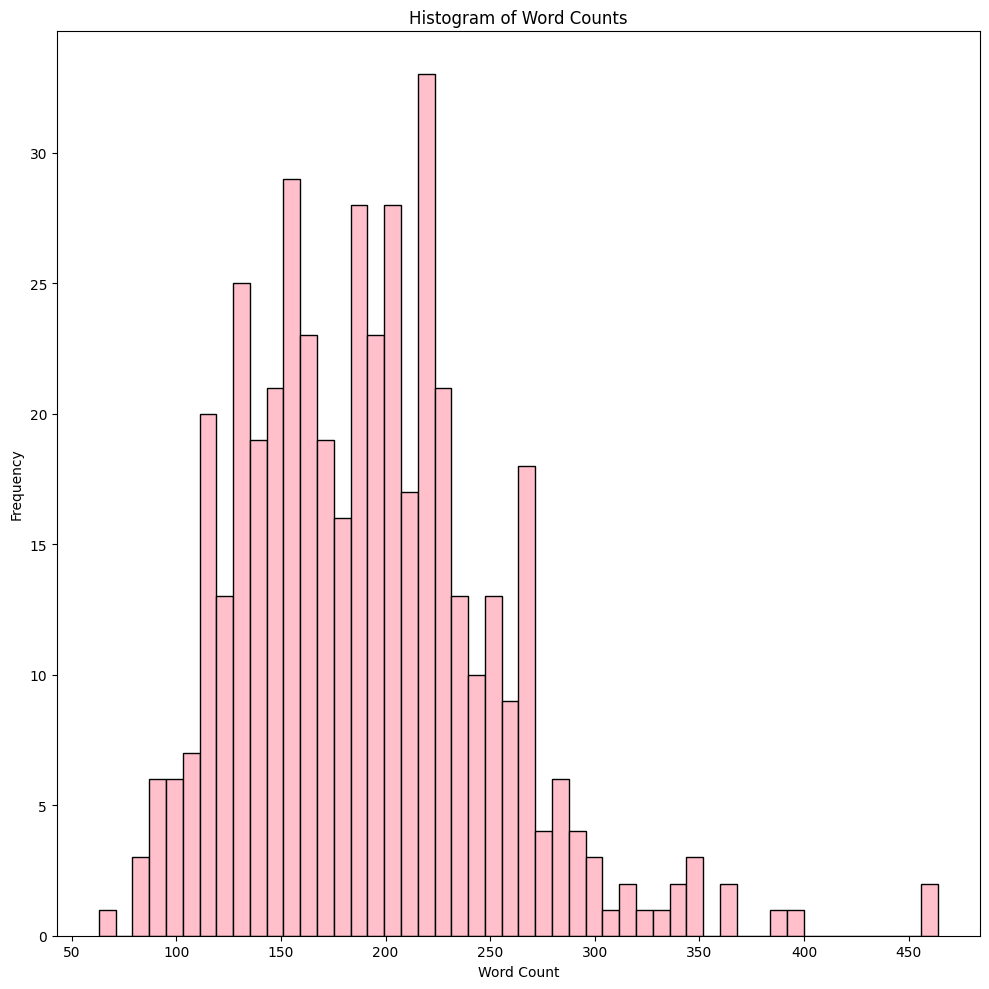

In [18]:
import matplotlib.pyplot as plt
x = train_data['count_word']
plt.figure(figsize=(10, 10))
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts')
plt.hist(x, bins=50, color='pink', edgecolor='black')
plt.tight_layout()
plt.show()

## Plot the frequency of each label in the dataset

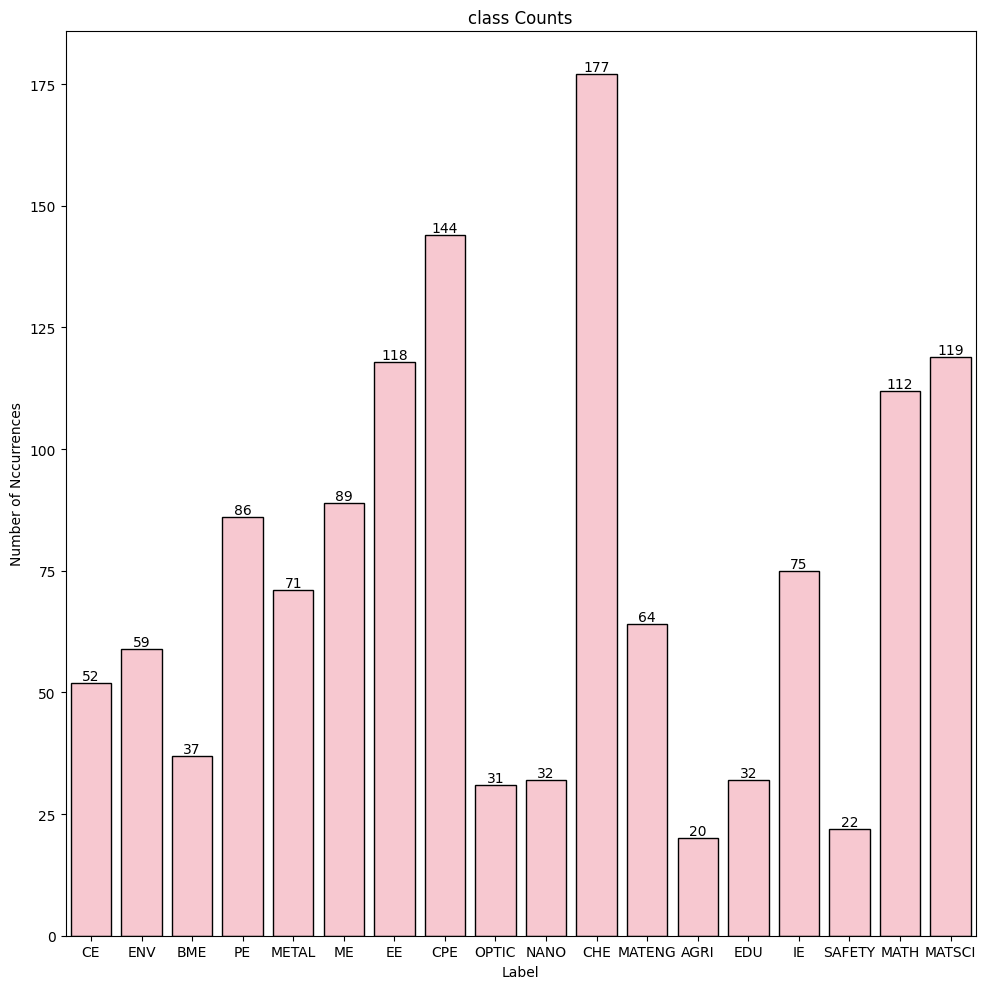

In [66]:
x = train_data.iloc[:, 2:-1].sum()
plt.figure(figsize=(10, 10))
plt.title("class Counts")
plt.ylabel('Number of Nccurrences')
plt.xlabel('Label')
ax = sns.barplot(x=x.index, y=x.values, color='pink', edgecolor='black')
for rect, label in zip(ax.patches, x.values):
    ax.text(rect.get_x() + rect.get_width()/2,
            rect.get_height(), label, ha='center', va='bottom')
plt.tight_layout()
plt.show()

## Plot number of lebels per articles

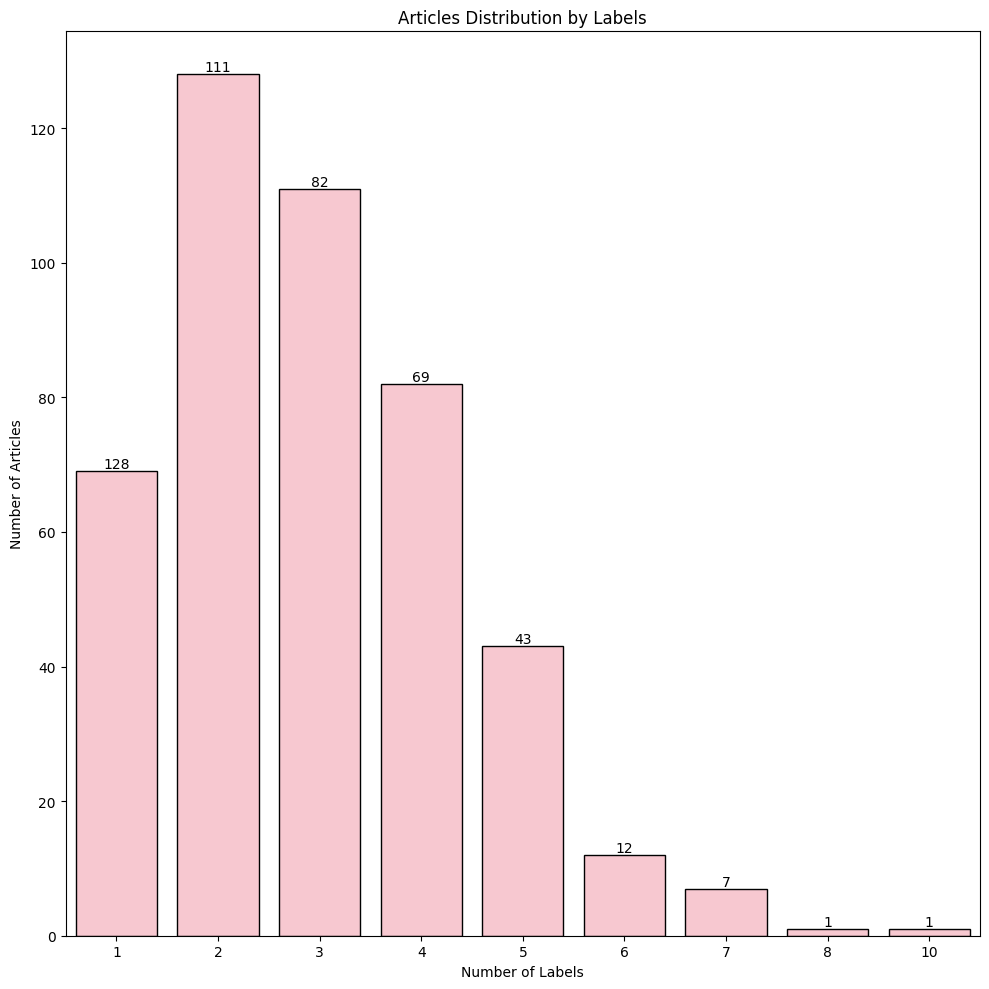

In [64]:
x = train_data.iloc[:, 2:-1].sum(axis=1).value_counts()
plt.figure(figsize=(10, 10))
plt.title('Articles Distribution by Labels')
plt.ylabel('Number of Articles')
plt.xlabel('Number of Labels')
ax = sns.barplot(x=x.index, y=x.values, color="pink", edgecolor="black")
for rect, label in zip(ax.patches, x.values):
    ax.text(rect.get_x() + rect.get_width()/2,
            rect.get_height(), label, ha='center', va='bottom')
plt.tight_layout()
plt.show()

After investigating the data, we've identified outliers. Specifically, we need to remove articles that have more than seven labels and 256 words, remove numbers in the text, remove stop words, and lemmatize words. Upon reviewing the data, we noticed the presence of many specific words, so we will delete those as well.


## Clean the data and save it to a CSV file.

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


def clean_text(text):
    sw = {'iii', 'wright-giemsa', 'ltdkraft', 'industrywe', 'walter', 'chulalongkorn', 'any', 'montmorillonite', 'dsas', 'tend', 'week', 'corresponding', 'ovo', 'depending', 'tasa', 'tnf', 'kongkrailart', 'asme', 'suggests', 'resulting', 'versus', 'of', 'edp', 'saraburi', 'support', 'assumed', 'proportionally', 'mm', 'investigate', 'proposes', 'faridi', 'sfrc', 'toward', 'year', 'province', 'nasef', 'b', 'freely', 'ieice', 'future', 'american', 'weeks', 'superior', 'decreasing', 'followed', 'pmampc', 'assume', 'aimed', 'day', 'beneficial', 'grover', 'chiang', 'pixhawk', 'illustrates', 'pdc', 'aidic', 'lotf', 'boston', 'abstract', 'lspllaah', 'disadvantage', 'therefore', 'bpmn', 'hundred', 'reasons', 'firstly', 'during', 'xilinx', 'al', 'called', 'desired', 'little', 'asia', 'germany', 'publishing', 'de', 'thb', 'cubems', 'provinces', 'bangkok', 'elsevier', 'newton', 'strongly', 'saphan', 'all', 'presented', 'servizi', 'kwh', 'objectives', 'thirdly', 'royal', 'seven', 'continuously', 'gmbh', 'discussed', 'granger', 'herein', 'weekly', 'sons', 'pacific', 'additional', 'singapore', 'berlin', 'decrease', 'gistda', 'depends', 'its', 'years', 'became', 'o', 'acm', 'improvement', 'nse', 'april', 'study', 'respectively', 'turbinaria', 'finally', 'days', 'positive', 'tvnlayy', 'so', 'nevertheless', 'moreover', 'pedro', 'finding', 'enterprise', 'revealed', 'xml', 'january', 'ltdnew', 'copyright', 'cambodia', 'three', 'proportional', 'significantly', 'kk', 'monthly', 'vietnam', 'taiwan', 'kheawhom', 'consider', 'institute', 'negatively', 'halcon', 'wise', 'cfd', 'psat', 'nuttun', 'hour', 'methodology', 'pearson', 'ova', 'jsme', 'contain', 'considers', 'licence', 'thailand', 'hours', 'ply', 'aim', 'wiley', 'mql', 'illustrate', 'exclusiveness', 'result', 'cytokine', 'various', 'chula', 'found', 'yom', 'carl', 'august', 'publish', 'zhao', 'compare', 'approximate', 'ieee', 'springer', 'bangrakam',
          'february', 'first', 'become', 'ieeethis', 'june', 'findings', 'th', 'abouzari', 'cox', 'a', 'two', 'undesired', 'bacillus', 'majidi', 'virojboonkiate', 'rai', 'thomas', 'other', 'tongji', 'ieeethe', 'discuss', 'increasing', 'iop', 'reveal', 'bmj', 'verlag', 'proportion', 'turkiye', 'discussion', 'apple', 'choong', 'average', 'thai', 'response', 'best', 'according', 'chexal', 'especially', 'switzerland', 'show', 'negative', 'hin', 'better', 'instead', 'consequently', 'march', 'nan', 'uk', 'recent', 'porites', 'may', 'research', 'kassel', 'reveals', 'abbasi', 'significant', 'aims', 'ltda', 'somwangthanaroj', 'america', 'make', 'paper', 'july', 'berlin/boston', 'nd', 'msd', 'secondly', 'nudus', 'october', 'color', 'tresatayawed', 'advance', 'present', 'advantage', 'authors', 'presents', 'techna', 'telnet', 'nowadays', 'ieeeover', 'et', 'few', 'hankel', 'follow', 'indonesia', 'one', 'asean', 'suggest', 'project', 'bismuth', 'gruyter', 'well', 'anchale', 'raphson', 'ltd', 'covid', 'able', 'congress', 'ladkrabang', 'apoz', 'also', 'effectiveness', 'each', 'sphaericus', 'whereas', 'suggested', 'thus', 'slam', 'university', 'november', 'sipunculus', 'positively', 'daily', 'later', 'december', 'st', 'illustrated', 'samutprakarn', 'telford', 'agns', 'v', 'believed', 'oxyhalide', 'laos', 'jeopardize', 'already', 'lorawan', 'researcher', 'klinikleri', 'regardless', 'value', 'phitsanulok', 'month', 'license', 'cause', 'late', 'dario', 'phuket', 'john', 'alumina', 'increase', 'takeshi', 'rajjaprabha', 'japan', 'several', 'considering', 'eighty', 'inos', 'international', 'studied', 'malaysia', 'massachusetts', 'hanser', 'marquardt', 'levenberg', 'between', 'recently', 'picoblaze', 'rhodamine', 'analysis', 'september', 'ltdhouse', 'tmr', 'concord', 'fuji', 'varying', 'objective', 'socalled', 'association', 'limitation', 'googleplay', 'published', 'author', 'babadi', 'betaproteobacteria', 'and'}
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    stop_words.update(sw)
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(tokens)
    return text


def train_to_csv_clean(r, w):
    with open(r, "r") as f:
        data = json.load(f)

    with open(w, "w", newline='', encoding='utf-8') as csv_file:
        fieldnames = ["id", "text"] + labels
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for key, value in data.items():
            label_count = sum(
                1 for field in fieldnames[2:] if field in value["Classes"])
            cleaned_text = clean_text(value["Title"] + " " + value["Abstract"])
            if label_count <= 7 and len(cleaned_text.split()) <= 256:
                row = {"id": key,
                       "text": cleaned_text}
                for field in fieldnames[2:]:
                    row[field] = 1 if field in value["Classes"] else 0
                writer.writerow(row)


def test_to_csv_clean(r, w):
    with open(r, "r") as f:
        data = json.load(f)
    with open(w, "w", newline='', encoding='utf-8') as csv_file:
        fieldnames = ['id', 'text']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for key, value in data.items():
            row = {"id": key,
                   "text": clean_text(value["Title"] + " " + value["Abstract"])}
            writer.writerow(row)

In [ ]:
train_to_csv("data/student_json/train_for_student.json",
             "data/student_csv/train_for_student.csv")

test_to_csv("data/student_json/test_for_student.json",
            "data/student_csv/test_for_student.csv")

In [13]:
train_data_clean = pd.read_csv('data/clean/train_for_student_clean.csv')
test_data_clean = pd.read_csv('data/clean/test_for_student_clean.csv')
train_data_clean['count_word'] = train_data_clean['text'].apply(lambda x: len(x.split()))
test_data_clean['count_word'] = train_data_clean['text'].apply(lambda x: len(x.split()))

In [15]:
train_data_clean['count_word'].describe()

count    451.000000
mean     113.079823
std       33.427505
min       43.000000
25%       88.000000
50%      110.000000
75%      134.500000
max      246.000000
Name: count_word, dtype: float64

In [16]:
test_data_clean['count_word'].describe()

count    151.000000
mean     115.867550
std       35.171328
min       43.000000
25%       88.500000
50%      111.000000
75%      137.500000
max      239.000000
Name: count_word, dtype: float64

Upload the cleaned file to Google Drive to train it on Colab.